In [1]:
import penaltyblog as pb
import pandas as pd
import numpy as np
import datetime as dt
from tqdm import tqdm
import soccerdata as sd
import optuna

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

pd.set_option('display.max_columns', None)

[01/31/26 17:22:47] INFO     No custom team name replacements found. You can configure these in       ]8;id=427112;file:///opt/anaconda3/envs/match_prediction/lib/python3.12/site-packages/soccerdata/_config.py\_config.py]8;;\:]8;id=815953;file:///opt/anaconda3/envs/match_prediction/lib/python3.12/site-packages/soccerdata/_config.py#92\92]8;;\
                             /Users/jaakkotoivonen/soccerdata/config/teamname_replacements.json.                   

                    INFO     No custom league dict found. You can configure additional leagues in    ]8;id=380428;file:///opt/anaconda3/envs/match_prediction/lib/python3.12/site-packages/soccerdata/_config.py\_config.py]8;;\:]8;id=650429;file:///opt/anaconda3/envs/match_prediction/lib/python3.12/site-packages/soccerdata/_config.py#198\198]8;;\
                             /Users/jaakkotoivonen/soccerdata/config/league_dict.json.                             

# Data

In [2]:
seasons = [2018, 2019, 2020, 2021, 2022, 2023, 2024]
leagues = ["ENG-Premier League", "ESP-La Liga", "FRA-Ligue 1", "GER-Bundesliga", "ITA-Serie A"]
sofascore = sd.Sofascore(leagues=leagues, seasons=seasons)
matches = sofascore.read_schedule()
matches = matches.reset_index()
display(matches.head())
display(matches.tail())
display(matches.shape)

[01/31/26 17:22:49] INFO     Saving cached data to /Users/jaakkotoivonen/soccerdata/data/Sofascore   ]8;id=389379;file:///opt/anaconda3/envs/match_prediction/lib/python3.12/site-packages/soccerdata/_common.py\_common.py]8;;\:]8;id=940058;file:///opt/anaconda3/envs/match_prediction/lib/python3.12/site-packages/soccerdata/_common.py#249\249]8;;\

[2026-01-31 17:22:49] INFO     TLSLibrary:_load_library:397 - Successfully loaded TLS library: /opt/anaconda3/envs/match_prediction/lib/python3.12/site-packages/tls_requests/bin/tls-client-darwin-arm64-1.13.1.dylib


                    INFO     Successfully loaded TLS library:                                      ]8;id=228993;file:///opt/anaconda3/envs/match_prediction/lib/python3.12/site-packages/tls_requests/models/libraries.py\libraries.py]8;;\:]8;id=554826;file:///opt/anaconda3/envs/match_prediction/lib/python3.12/site-packages/tls_requests/models/libraries.py#397\397]8;;\
                             /opt/anaconda3/envs/match_prediction/lib/python3.12/site-packages/tls                 
                             _requests/bin/tls-client-darwin-arm64-1.13.1.dylib                                    

                    WARNING  /opt/anaconda3/envs/match_prediction/lib/python3.12/site-packages/socc ]8;id=140355;file:///opt/anaconda3/envs/match_prediction/lib/python3.12/warnings.py\warnings.py]8;;\:]8;id=374568;file:///opt/anaconda3/envs/match_prediction/lib/python3.12/warnings.py#112\112]8;;\
                             erdata/_common.py:143: UserWarning: Season id "2021" is ambiguous:                    
                             interpreting as "20-21"                                                               
                               warnings.warn(msg, stacklevel=1)                                                    
                                                                                                                   

,league,season,game,round,week,date,home_team,away_team,home_score,away_score,game_id
0,ENG-Premier League,1819,2018-08-10 Manchester United-Leicester City,1,1,2018-08-10 19:00:00+00:00,Manchester United,Leicester City,2,1,7827861
1,ENG-Premier League,1819,2018-08-11 Bournemouth-Cardiff City,1,1,2018-08-11 14:00:00+00:00,Bournemouth,Cardiff City,2,0,7827862
2,ENG-Premier League,1819,2018-08-11 Fulham-Crystal Palace,1,1,2018-08-11 14:00:00+00:00,Fulham,Crystal Palace,0,2,7827865
3,ENG-Premier League,1819,2018-08-11 Huddersfield Town-Chelsea,1,1,2018-08-11 14:00:00+00:00,Huddersfield Town,Chelsea,0,3,7827864
4,ENG-Premier League,1819,2018-08-11 Newcastle United-Tottenham Hotspur,1,1,2018-08-11 11:30:00+00:00,Newcastle United,Tottenham Hotspur,1,2,7827868


,league,season,game,round,week,date,home_team,away_team,home_score,away_score,game_id
10880,ITA-Serie A,2425,2025-05-25 Empoli-Hellas Verona,38,38,2025-05-25 18:45:00+00:00,Empoli,Hellas Verona,1,2,12501519
10881,ITA-Serie A,2425,2025-05-25 Lazio-Lecce,38,38,2025-05-25 18:45:00+00:00,Lazio,Lecce,0,1,12501517
10882,ITA-Serie A,2425,2025-05-25 Torino-Roma,38,38,2025-05-25 18:45:00+00:00,Torino,Roma,0,2,12501508
10883,ITA-Serie A,2425,2025-05-25 Udinese-Fiorentina,38,38,2025-05-25 18:45:00+00:00,Udinese,Fiorentina,2,3,12501527
10884,ITA-Serie A,2425,2025-05-25 Venezia-Juventus,38,38,2025-05-25 18:45:00+00:00,Venezia,Juventus,2,3,12501507


(10885, 11)

In [3]:
matches.groupby(['league', 'season']).size().reset_index(name='num_matches')

,league,season,num_matches
0,ENG-Premier League,1819,380
1,ENG-Premier League,1920,380
2,ENG-Premier League,2021,380
3,ENG-Premier League,2223,380
4,ENG-Premier League,2324,380
5,ENG-Premier League,2425,380
6,ESP-La Liga,1819,380
7,ESP-La Liga,1920,380
8,ESP-La Liga,2021,380
9,ESP-La Liga,2223,380


# Model tuning

In [4]:
from sklearn.metrics import brier_score_loss

def sliding_window_dixon_coles_predictions(matches, window_size=365, prediction_days=14, xi=0.0018):
    """
    Train Dixon-Coles models using a sliding time window and make predictions for future matches.
    
    Parameters:
    -----------
    matches : pd.DataFrame
        DataFrame with columns: 'league', 'date', 'home_team', 'away_team', 'home_score', 'away_score'
    window_size : int
        Size of the sliding window in days for training (default: 365)
    prediction_days : int
        Number of days ahead to predict (default: 14)
    xi : float
        Weighting parameter for Dixon-Coles model (default: 0.0018)
    
    Returns:
    --------
    predictions_df : pd.DataFrame
        DataFrame containing predictions for each league and match, including actual scores and Brier scores
    """
    
    predictions = []
    
    # Get unique leagues
    leagues = matches['league'].unique()
    
    for league in leagues:
        print(f"Processing league: {league}")
        
        # Filter matches for the current league
        league_matches = matches[matches['league'] == league].copy()
        league_matches['date'] = pd.to_datetime(league_matches['date'])
        league_matches = league_matches.sort_values('date').reset_index(drop=True)
        
        # Get date range for this league
        min_date = league_matches['date'].min()
        max_date = league_matches['date'].max()
        
        # Start with the first training window
        training_window_start = min_date
        training_window_end = min_date + pd.Timedelta(days=window_size)
        
        while training_window_end <= max_date:
            # Get training data (exactly window_size days)
            training_data = league_matches[
                (league_matches['date'] >= training_window_start) & 
                (league_matches['date'] < training_window_end) &
                (league_matches['home_score'].notna()) &
                (league_matches['away_score'].notna())
            ].copy()
            
            if len(training_data) < 190:  # Skip if not enough data
                training_window_start += pd.Timedelta(days=7)
                training_window_end += pd.Timedelta(days=7)
                continue
            
            # Get prediction window (next prediction_days)
            prediction_window_start = training_window_end
            prediction_window_end = training_window_end + pd.Timedelta(days=prediction_days)
            
            # Get matches to predict
            future_matches = league_matches[
                (league_matches['date'] >= prediction_window_start) & 
                (league_matches['date'] < prediction_window_end) 
            ].copy()
            
            if len(future_matches) == 0:
                training_window_start += pd.Timedelta(days=7)
                training_window_end += pd.Timedelta(days=7)
                continue
            
            try:
                # Train Dixon-Coles model
                weights = pb.models.dixon_coles_weights(training_data["date"], xi)
                
                clf = pb.models.DixonColesGoalModel(
                    training_data["home_score"],
                    training_data["away_score"],
                    training_data["home_team"],
                    training_data["away_team"],
                    weights
                )
                clf.fit()
                
                # Make predictions for future matches
                for _, match in future_matches.iterrows():
                    prediction = clf.predict(match['home_team'], match['away_team'])
                    
                    home_goals_pred = prediction.home_goal_expectation
                    away_goals_pred = prediction.away_goal_expectation
                    
                    # Determine predicted outcome
                    if home_goals_pred > away_goals_pred:
                        predicted_outcome = 'home_win'
                    elif home_goals_pred < away_goals_pred:
                        predicted_outcome = 'away_win'
                    else:
                        predicted_outcome = 'draw'
                    
                    # Get actual outcome (if match has been played)
                    actual_home_score = match['home_score']
                    actual_away_score = match['away_score']
                    
                    if pd.notna(actual_home_score) and pd.notna(actual_away_score):
                        actual_home_score = int(actual_home_score)
                        actual_away_score = int(actual_away_score)
                        
                        # Determine actual outcome
                        if actual_home_score > actual_away_score:
                            actual_outcome = 'home_win'
                        elif actual_home_score < actual_away_score:
                            actual_outcome = 'away_win'
                        else:
                            actual_outcome = 'draw'
                        
                        # Calculate Brier score for outcome prediction
                        # Convert outcomes to binary: 1 if prediction matches actual, 0 otherwise
                        outcome_correct = 1.0 if predicted_outcome == actual_outcome else 0.0
                        brier_outcome = brier_score_loss([outcome_correct], [1.0])
                        
                        # Calculate Brier score for goal predictions (normalized)
                        # Normalize predictions and actual scores for comparison
                        predicted_goals = [home_goals_pred, away_goals_pred]
                        actual_goals = [actual_home_score, actual_away_score]
                        
                        # Brier score for individual goal predictions
                        brier_home = (home_goals_pred - actual_home_score) ** 2
                        brier_away = (away_goals_pred - actual_away_score) ** 2
                        brier_total = (brier_home + brier_away) / 2
                        
                    else:
                        actual_home_score = None
                        actual_away_score = None
                        actual_outcome = None
                        brier_outcome = None
                        brier_home = None
                        brier_away = None
                        brier_total = None
                    
                    predictions.append({
                        'league': league,
                        'training_window_start': training_window_start,
                        'training_window_end': training_window_end,
                        'match_date': match['date'],
                        'home_team': match['home_team'],
                        'away_team': match['away_team'],
                        'predicted_home_goals': home_goals_pred,
                        'predicted_away_goals': away_goals_pred,
                        'predicted_outcome': predicted_outcome,
                        'actual_home_score': actual_home_score,
                        'actual_away_score': actual_away_score,
                        'actual_outcome': actual_outcome,
                        'brier_home_goals': brier_home,
                        'brier_away_goals': brier_away,
                        'brier_total_goals': brier_total,
                        'brier_outcome': brier_outcome,
                        'training_matches': len(training_data)
                    })
                
            except Exception as e:
                print(f"Error training model for {league} between {training_window_start} and {training_window_end}: {e}")
                training_window_start += pd.Timedelta(days=7)
                training_window_end += pd.Timedelta(days=7)
                continue
            
            # Move to the next window (e.g., weekly)
            training_window_start += pd.Timedelta(days=7)
            training_window_end += pd.Timedelta(days=7)
    
    # Convert predictions to DataFrame
    predictions_df = pd.DataFrame(predictions)
    return predictions_df


# Usage example:
# predictions = sliding_window_dixon_coles_predictions(matches, window_size=365, prediction_days=14)
# print(predictions)

In [5]:
def objective(trial):
    xi = trial.suggest_float('xi', 0.0001, 0.01)
    window_size = trial.suggest_int('window_size', 180, 1095)
    preds = sliding_window_dixon_coles_predictions(matches, window_size=window_size, prediction_days=14, xi=xi)
    return preds.brier_total_goals.mean()

In [10]:
def plot_optuna_study(study):
    '''PLOT INFORMATION FROM THE HYPER-PARAMETER TRAINING RUN'''

    print('OPTIMIZATION TRIALS DATA')
    test_scores = [study.get_trials()[i].values[0] for i in range(0,len(study.get_trials()))]
    params = [pd.DataFrame(study.get_trials()[i].params, index=[i]) for i in range(0,len(study.get_trials()))]
    trial_data = pd.concat(params)
    trial_data[f'test mse'] = test_scores

    # plot trial data
    trial_data.plot(subplots=True)
    plt.show()

    print('BEST TRIAL PARAMETERS')
    print(study.best_params)

    return trial_data

## Run optimization

In [7]:
study = optuna.create_study()
study.optimize(objective, n_trials=100)

[I 2026-01-31 17:22:57,201] A new study created in memory with name: no-name-e08ca24a-abae-4a9c-b17b-cfa503b57044


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2018-11-09 19:00:00+00:00 and 2019-08-02 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2018-11-16 19:00:00+00:00 and 2019-08-09 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2019-12-13 19:00:00+00:00 and 2020-09-04 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2019-12-20 19:00:00+00:00 and 2020-09-11 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-11-11 19:00:00+00:00 and 2023-08-04 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-11-18 19:00:00+00:00 and 2023-08-11 19:00:00+00:00: Both teams must have been in the training data.
Error training model

[I 2026-01-31 17:23:26,174] Trial 0 finished with value: 1.421292236391531 and parameters: {'xi': 0.004918602782410317, 'window_size': 266}. Best is trial 0 with value: 1.421292236391531.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2019-08-09 19:00:00+00:00 and 2022-07-26 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2019-08-16 19:00:00+00:00 and 2022-08-02 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-08-14 19:00:00+00:00 and 2023-08-01 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-08-21 19:00:00+00:00 and 2023-08-08 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-08-20 19:00:00+00:00 and 2024-08-06 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-08-27 19:00:00+00:00 and 2024-08-13 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 17:24:26,082] Trial 1 finished with value: 1.5122519774584828 and parameters: {'xi': 0.008437246209983576, 'window_size': 1082}. Best is trial 0 with value: 1.421292236391531.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2018-11-30 19:00:00+00:00 and 2019-08-02 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2018-12-07 19:00:00+00:00 and 2019-08-09 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-12-02 19:00:00+00:00 and 2023-08-04 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-12-09 19:00:00+00:00 and 2023-08-11 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2023-12-08 19:00:00+00:00 and 2024-08-09 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2023-12-15 19:00:00+00:00 and 2024-08-16 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 17:24:52,184] Trial 2 finished with value: 1.4060360391487012 and parameters: {'xi': 0.00524132873102297, 'window_size': 245}. Best is trial 2 with value: 1.4060360391487012.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2023-01-20 19:00:00+00:00 and 2023-08-03 19:00:00+00:00: Both teams must have been in the training data.
Processing league: ESP-La Liga
Error training model for ESP-La Liga between 2023-01-20 18:15:00+00:00 and 2023-08-03 18:15:00+00:00: Both teams must have been in the training data.
Error training model for ESP-La Liga between 2023-01-27 18:15:00+00:00 and 2023-08-10 18:15:00+00:00: Both teams must have been in the training data.
Processing league: FRA-Ligue 1
Error training model for FRA-Ligue 1 between 2023-01-20 18:45:00+00:00 and 2023-08-03 18:45:00+00:00: Both teams must have been in the training data.
Error training model for FRA-Ligue 1 between 2023-01-27 18:45:00+00:00 and 2023-08-10 18:45:00+00:00: Both teams must have been in the training data.
Processing league: GER-Bundesliga
Processing league: ITA-Serie A
Error training model for ITA-Serie A between 2023-01-28 16:00:00+00:00 and 202

[I 2026-01-31 17:25:06,898] Trial 3 finished with value: 1.3982054623401199 and parameters: {'xi': 0.006162320873823889, 'window_size': 195}. Best is trial 3 with value: 1.3982054623401199.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2018-10-26 19:00:00+00:00 and 2020-09-03 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2018-11-02 19:00:00+00:00 and 2020-09-10 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-09-18 19:00:00+00:00 and 2022-07-28 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-09-25 19:00:00+00:00 and 2022-08-04 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-09-24 19:00:00+00:00 and 2023-08-03 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-10-01 19:00:00+00:00 and 2023-08-10 19:00:00+00:00: Both teams must have been in the training data.
Error training model

[I 2026-01-31 17:26:02,429] Trial 4 finished with value: 1.3960332831460882 and parameters: {'xi': 0.0006063617283890148, 'window_size': 678}. Best is trial 4 with value: 1.3960332831460882.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2018-12-21 19:00:00+00:00 and 2019-08-01 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2018-12-28 19:00:00+00:00 and 2019-08-08 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-12-23 19:00:00+00:00 and 2023-08-03 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-12-30 19:00:00+00:00 and 2023-08-10 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2023-12-29 19:00:00+00:00 and 2024-08-08 19:00:00+00:00: Both teams must have been in the training data.
Processing league: ESP-La Liga
Error training model for ESP-La Liga between 2018-12-28 18:15:00+00:00 and 2019-08-08 18:15:00+00:00: Both teams must have been in the training da

[I 2026-01-31 17:26:23,733] Trial 5 finished with value: 1.391983676807142 and parameters: {'xi': 0.005175842110964962, 'window_size': 223}. Best is trial 5 with value: 1.391983676807142.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2019-09-13 19:00:00+00:00 and 2022-07-29 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2019-09-20 19:00:00+00:00 and 2022-08-05 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-09-18 19:00:00+00:00 and 2023-08-04 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-09-25 19:00:00+00:00 and 2023-08-11 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-09-24 19:00:00+00:00 and 2024-08-09 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-10-01 19:00:00+00:00 and 2024-08-16 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 17:27:20,125] Trial 6 finished with value: 1.3876254891697613 and parameters: {'xi': 0.0012360197887088455, 'window_size': 1050}. Best is trial 6 with value: 1.3876254891697613.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2018-12-14 19:00:00+00:00 and 2019-07-28 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2018-12-21 19:00:00+00:00 and 2019-08-04 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-12-16 19:00:00+00:00 and 2023-07-30 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-12-23 19:00:00+00:00 and 2023-08-06 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2023-12-22 19:00:00+00:00 and 2024-08-04 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2023-12-29 19:00:00+00:00 and 2024-08-11 19:00:00+00:00: Both teams must have been in the training data.
Error training model

[I 2026-01-31 17:27:45,766] Trial 7 finished with value: 1.3861582640318735 and parameters: {'xi': 0.0016960940789253899, 'window_size': 226}. Best is trial 7 with value: 1.3861582640318735.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2020-01-17 19:00:00+00:00 and 2022-07-28 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-01-24 19:00:00+00:00 and 2022-08-04 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-01-22 19:00:00+00:00 and 2023-08-03 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-01-29 19:00:00+00:00 and 2023-08-10 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-01-28 19:00:00+00:00 and 2024-08-08 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-02-04 19:00:00+00:00 and 2024-08-15 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 17:28:41,234] Trial 8 finished with value: 1.4555504335306384 and parameters: {'xi': 0.006676943654097722, 'window_size': 923}. Best is trial 7 with value: 1.3861582640318735.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2018-08-10 19:00:00+00:00 and 2020-09-06 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-06-26 19:00:00+00:00 and 2022-07-24 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-07-03 19:00:00+00:00 and 2022-07-31 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-07-02 19:00:00+00:00 and 2023-07-30 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-07-09 19:00:00+00:00 and 2023-08-06 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-07-08 19:00:00+00:00 and 2024-08-04 19:00:00+00:00: Both teams must have been in the training data.
Error training model

[I 2026-01-31 17:29:36,985] Trial 9 finished with value: 1.4081976809463241 and parameters: {'xi': 0.0038260467886191097, 'window_size': 758}. Best is trial 7 with value: 1.3861582640318735.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2019-05-31 19:00:00+00:00 and 2020-09-04 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2019-06-07 19:00:00+00:00 and 2020-09-11 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-04-29 19:00:00+00:00 and 2023-08-04 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-05-06 19:00:00+00:00 and 2023-08-11 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2023-05-05 19:00:00+00:00 and 2024-08-09 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2023-05-12 19:00:00+00:00 and 2024-08-16 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 17:30:18,770] Trial 10 finished with value: 1.3854907816481252 and parameters: {'xi': 0.002765841795937013, 'window_size': 462}. Best is trial 10 with value: 1.3854907816481252.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2019-05-24 19:00:00+00:00 and 2020-09-01 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2019-05-31 19:00:00+00:00 and 2020-09-08 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-04-22 19:00:00+00:00 and 2023-08-01 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-04-29 19:00:00+00:00 and 2023-08-08 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2023-04-28 19:00:00+00:00 and 2024-08-06 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2023-05-05 19:00:00+00:00 and 2024-08-13 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 17:31:00,908] Trial 11 finished with value: 1.3840638116102784 and parameters: {'xi': 0.002096510216781158, 'window_size': 466}. Best is trial 11 with value: 1.3840638116102784.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2019-06-14 19:00:00+00:00 and 2020-08-30 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2019-06-21 19:00:00+00:00 and 2020-09-06 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-05-13 19:00:00+00:00 and 2023-07-30 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-05-20 19:00:00+00:00 and 2023-08-06 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2023-05-19 19:00:00+00:00 and 2024-08-04 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2023-05-26 19:00:00+00:00 and 2024-08-11 19:00:00+00:00: Both teams must have been in the training data.
Error training model

[I 2026-01-31 17:31:42,700] Trial 12 finished with value: 1.3859648571124357 and parameters: {'xi': 0.0029590776798230326, 'window_size': 443}. Best is trial 11 with value: 1.3840638116102784.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2019-04-26 19:00:00+00:00 and 2020-09-02 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2019-05-03 19:00:00+00:00 and 2020-09-09 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-03-25 19:00:00+00:00 and 2023-08-02 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-04-01 19:00:00+00:00 and 2023-08-09 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2023-03-31 19:00:00+00:00 and 2024-08-07 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2023-04-07 19:00:00+00:00 and 2024-08-14 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 17:32:25,060] Trial 13 finished with value: 1.3829130848461098 and parameters: {'xi': 0.0023425794220917084, 'window_size': 495}. Best is trial 13 with value: 1.3829130848461098.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2019-06-07 19:00:00+00:00 and 2020-09-01 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2019-06-14 19:00:00+00:00 and 2020-09-08 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-05-06 19:00:00+00:00 and 2023-08-01 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-05-13 19:00:00+00:00 and 2023-08-08 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2023-05-12 19:00:00+00:00 and 2024-08-06 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2023-05-19 19:00:00+00:00 and 2024-08-13 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 17:33:08,168] Trial 14 finished with value: 1.383662702246713 and parameters: {'xi': 0.0022450274468192835, 'window_size': 452}. Best is trial 13 with value: 1.3829130848461098.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2019-02-15 19:00:00+00:00 and 2020-09-04 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2019-02-22 19:00:00+00:00 and 2020-09-11 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-01-08 19:00:00+00:00 and 2022-07-29 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-01-15 19:00:00+00:00 and 2022-08-05 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-01-14 19:00:00+00:00 and 2023-08-04 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-01-21 19:00:00+00:00 and 2023-08-11 19:00:00+00:00: Both teams must have been in the training data.
Error training model

[I 2026-01-31 17:33:54,857] Trial 15 finished with value: 1.3918220398423102 and parameters: {'xi': 0.00011633524881103207, 'window_size': 567}. Best is trial 13 with value: 1.3829130848461098.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2019-08-23 19:00:00+00:00 and 2020-08-30 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2019-08-30 19:00:00+00:00 and 2020-09-06 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-07-22 19:00:00+00:00 and 2023-07-30 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-07-29 19:00:00+00:00 and 2023-08-06 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2023-07-28 19:00:00+00:00 and 2024-08-04 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2023-08-04 19:00:00+00:00 and 2024-08-11 19:00:00+00:00: Both teams must have been in the training data.
Error training model

[I 2026-01-31 17:34:34,996] Trial 16 finished with value: 1.4002030308902935 and parameters: {'xi': 0.003809626065550768, 'window_size': 373}. Best is trial 13 with value: 1.3829130848461098.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2019-02-01 19:00:00+00:00 and 2020-09-04 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2019-02-08 19:00:00+00:00 and 2020-09-11 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-12-25 19:00:00+00:00 and 2022-07-29 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-01-01 19:00:00+00:00 and 2022-08-05 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-12-31 19:00:00+00:00 and 2023-08-04 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-01-07 19:00:00+00:00 and 2023-08-11 19:00:00+00:00: Both teams must have been in the training data.
Error training model

[I 2026-01-31 17:35:15,875] Trial 17 finished with value: 1.5056337232129953 and parameters: {'xi': 0.009121920221965956, 'window_size': 581}. Best is trial 13 with value: 1.3829130848461098.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2020-05-08 19:00:00+00:00 and 2022-07-25 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-05-15 19:00:00+00:00 and 2022-08-01 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-05-14 19:00:00+00:00 and 2023-07-31 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-05-21 19:00:00+00:00 and 2023-08-07 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-05-20 19:00:00+00:00 and 2024-08-05 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-05-27 19:00:00+00:00 and 2024-08-12 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 17:36:12,264] Trial 18 finished with value: 1.3905253518682699 and parameters: {'xi': 0.003676299736336254, 'window_size': 808}. Best is trial 13 with value: 1.3829130848461098.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2018-08-10 19:00:00+00:00 and 2019-08-04 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2019-09-06 19:00:00+00:00 and 2020-08-30 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2019-09-13 19:00:00+00:00 and 2020-09-06 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-08-05 19:00:00+00:00 and 2023-07-30 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-08-12 19:00:00+00:00 and 2023-08-06 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2023-08-11 19:00:00+00:00 and 2024-08-04 19:00:00+00:00: Both teams must have been in the training data.
Error training model

[I 2026-01-31 17:36:52,880] Trial 19 finished with value: 1.398436599026984 and parameters: {'xi': 0.002444277792641065, 'window_size': 359}. Best is trial 13 with value: 1.3829130848461098.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2019-02-15 19:00:00+00:00 and 2020-09-01 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2019-02-22 19:00:00+00:00 and 2020-09-08 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-01-08 19:00:00+00:00 and 2022-07-26 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-01-15 19:00:00+00:00 and 2022-08-02 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-01-14 19:00:00+00:00 and 2023-08-01 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-01-21 19:00:00+00:00 and 2023-08-08 19:00:00+00:00: Both teams must have been in the training data.
Error training model

[I 2026-01-31 17:37:38,887] Trial 20 finished with value: 1.3871064614277995 and parameters: {'xi': 0.0009562592904845185, 'window_size': 564}. Best is trial 13 with value: 1.3829130848461098.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2019-05-17 19:00:00+00:00 and 2020-08-29 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2019-05-24 19:00:00+00:00 and 2020-09-05 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2019-05-31 19:00:00+00:00 and 2020-09-12 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-04-15 19:00:00+00:00 and 2023-07-29 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-04-22 19:00:00+00:00 and 2023-08-05 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2023-04-21 19:00:00+00:00 and 2024-08-03 19:00:00+00:00: Both teams must have been in the training data.
Error training model

[I 2026-01-31 17:38:22,181] Trial 21 finished with value: 1.381045193287426 and parameters: {'xi': 0.0019461413922228854, 'window_size': 470}. Best is trial 21 with value: 1.381045193287426.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2018-08-10 19:00:00+00:00 and 2019-08-03 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2019-09-06 19:00:00+00:00 and 2020-08-29 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2019-09-13 19:00:00+00:00 and 2020-09-05 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2019-09-20 19:00:00+00:00 and 2020-09-12 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-08-05 19:00:00+00:00 and 2023-07-29 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-08-12 19:00:00+00:00 and 2023-08-05 19:00:00+00:00: Both teams must have been in the training data.
Error training model

[I 2026-01-31 17:39:03,649] Trial 22 finished with value: 1.3921242338884676 and parameters: {'xi': 0.0016036048195941111, 'window_size': 358}. Best is trial 21 with value: 1.381045193287426.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2018-11-30 19:00:00+00:00 and 2020-09-03 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2018-12-07 19:00:00+00:00 and 2020-09-10 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-10-23 19:00:00+00:00 and 2022-07-28 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-10-30 19:00:00+00:00 and 2022-08-04 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-10-29 19:00:00+00:00 and 2023-08-03 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-11-05 19:00:00+00:00 and 2023-08-10 19:00:00+00:00: Both teams must have been in the training data.
Error training model

[I 2026-01-31 17:39:54,410] Trial 23 finished with value: 1.4074497586849772 and parameters: {'xi': 0.0032269571471714724, 'window_size': 643}. Best is trial 21 with value: 1.381045193287426.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2019-03-22 19:00:00+00:00 and 2020-08-29 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2019-03-29 19:00:00+00:00 and 2020-09-05 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2019-04-05 19:00:00+00:00 and 2020-09-12 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-02-18 19:00:00+00:00 and 2023-07-29 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-02-25 19:00:00+00:00 and 2023-08-05 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2023-02-24 19:00:00+00:00 and 2024-08-03 19:00:00+00:00: Both teams must have been in the training data.
Error training model

[I 2026-01-31 17:40:38,407] Trial 24 finished with value: 1.3767801536763073 and parameters: {'xi': 0.0022662834360009914, 'window_size': 526}. Best is trial 24 with value: 1.3767801536763073.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2019-03-22 19:00:00+00:00 and 2020-08-30 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2019-03-29 19:00:00+00:00 and 2020-09-06 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-02-18 19:00:00+00:00 and 2023-07-30 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-02-25 19:00:00+00:00 and 2023-08-06 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2023-02-24 19:00:00+00:00 and 2024-08-04 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2023-03-03 19:00:00+00:00 and 2024-08-11 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 17:41:21,498] Trial 25 finished with value: 1.3888847132343445 and parameters: {'xi': 0.004297350791425337, 'window_size': 527}. Best is trial 24 with value: 1.3767801536763073.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2018-09-14 19:00:00+00:00 and 2020-08-31 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2018-09-21 19:00:00+00:00 and 2020-09-07 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-08-07 19:00:00+00:00 and 2022-07-25 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-08-14 19:00:00+00:00 and 2022-08-01 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-08-13 19:00:00+00:00 and 2023-07-31 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-08-20 19:00:00+00:00 and 2023-08-07 19:00:00+00:00: Both teams must have been in the training data.
Error training model

[I 2026-01-31 17:42:18,780] Trial 26 finished with value: 1.3956570027225286 and parameters: {'xi': 0.0006839504962214242, 'window_size': 717}. Best is trial 24 with value: 1.3767801536763073.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2018-09-07 19:00:00+00:00 and 2019-07-29 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2018-09-14 19:00:00+00:00 and 2019-08-05 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2019-10-11 19:00:00+00:00 and 2020-08-31 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2019-10-18 19:00:00+00:00 and 2020-09-07 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-09-09 19:00:00+00:00 and 2023-07-31 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-09-16 19:00:00+00:00 and 2023-08-07 19:00:00+00:00: Both teams must have been in the training data.
Error training model

[I 2026-01-31 17:42:51,156] Trial 27 finished with value: 1.4299428722260925 and parameters: {'xi': 0.00691270827125324, 'window_size': 325}. Best is trial 24 with value: 1.3767801536763073.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2019-03-29 19:00:00+00:00 and 2020-09-04 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2019-04-05 19:00:00+00:00 and 2020-09-11 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-02-25 19:00:00+00:00 and 2023-08-04 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-03-04 19:00:00+00:00 and 2023-08-11 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2023-03-03 19:00:00+00:00 and 2024-08-09 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2023-03-10 19:00:00+00:00 and 2024-08-16 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 17:43:35,426] Trial 28 finished with value: 1.3801010837636747 and parameters: {'xi': 0.000127006779441334, 'window_size': 525}. Best is trial 24 with value: 1.3767801536763073.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2018-12-21 19:00:00+00:00 and 2020-08-29 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2018-12-28 19:00:00+00:00 and 2020-09-05 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2019-01-04 19:00:00+00:00 and 2020-09-12 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-11-13 19:00:00+00:00 and 2022-07-23 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-11-20 19:00:00+00:00 and 2022-07-30 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-11-27 19:00:00+00:00 and 2022-08-06 19:00:00+00:00: Both teams must have been in the training data.
Error training model

[I 2026-01-31 17:44:28,229] Trial 29 finished with value: 1.395769635614155 and parameters: {'xi': 0.00034103715440364556, 'window_size': 617}. Best is trial 24 with value: 1.3767801536763073.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2020-04-03 19:00:00+00:00 and 2022-07-28 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-04-10 19:00:00+00:00 and 2022-08-04 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-04-09 19:00:00+00:00 and 2023-08-03 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-04-16 19:00:00+00:00 and 2023-08-10 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-04-15 19:00:00+00:00 and 2024-08-08 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-04-22 19:00:00+00:00 and 2024-08-15 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 17:45:27,274] Trial 30 finished with value: 1.3722347899389962 and parameters: {'xi': 0.0014440236042104087, 'window_size': 846}. Best is trial 30 with value: 1.3722347899389962.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2020-02-28 19:00:00+00:00 and 2022-07-29 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-03-06 19:00:00+00:00 and 2022-08-05 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-03-05 19:00:00+00:00 and 2023-08-04 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-03-12 19:00:00+00:00 and 2023-08-11 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-03-11 19:00:00+00:00 and 2024-08-09 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-03-18 19:00:00+00:00 and 2024-08-16 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 17:46:25,391] Trial 31 finished with value: 1.376250260358281 and parameters: {'xi': 0.0012473003222956886, 'window_size': 882}. Best is trial 30 with value: 1.3722347899389962.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2020-01-17 19:00:00+00:00 and 2022-07-29 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-01-24 19:00:00+00:00 and 2022-08-05 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-01-22 19:00:00+00:00 and 2023-08-04 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-01-29 19:00:00+00:00 and 2023-08-11 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-01-28 19:00:00+00:00 and 2024-08-09 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-02-04 19:00:00+00:00 and 2024-08-16 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 17:47:23,026] Trial 32 finished with value: 1.3819060744420932 and parameters: {'xi': 0.001147821557486626, 'window_size': 924}. Best is trial 30 with value: 1.3722347899389962.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2020-03-20 19:00:00+00:00 and 2022-07-26 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-03-27 19:00:00+00:00 and 2022-08-02 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-03-26 19:00:00+00:00 and 2023-08-01 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-04-02 19:00:00+00:00 and 2023-08-08 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-04-01 19:00:00+00:00 and 2024-08-06 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-04-08 19:00:00+00:00 and 2024-08-13 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 17:48:24,192] Trial 33 finished with value: 1.3782675413485028 and parameters: {'xi': 0.00011082777496336732, 'window_size': 858}. Best is trial 30 with value: 1.3722347899389962.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2020-03-06 19:00:00+00:00 and 2022-07-23 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-03-13 19:00:00+00:00 and 2022-07-30 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-03-20 19:00:00+00:00 and 2022-08-06 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-03-12 19:00:00+00:00 and 2023-07-29 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-03-19 19:00:00+00:00 and 2023-08-05 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-03-18 19:00:00+00:00 and 2024-08-03 19:00:00+00:00: Both teams must have been in the training data.
Error training model

[I 2026-01-31 17:49:25,437] Trial 34 finished with value: 1.373394960596355 and parameters: {'xi': 0.001342438535665151, 'window_size': 869}. Best is trial 30 with value: 1.3722347899389962.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2019-10-25 19:00:00+00:00 and 2022-07-25 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2019-11-01 19:00:00+00:00 and 2022-08-01 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-10-30 19:00:00+00:00 and 2023-07-31 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-11-06 19:00:00+00:00 and 2023-08-07 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-11-05 19:00:00+00:00 and 2024-08-05 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-11-12 19:00:00+00:00 and 2024-08-12 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 17:50:20,940] Trial 35 finished with value: 1.3849603678284392 and parameters: {'xi': 0.0015328143799114798, 'window_size': 1004}. Best is trial 30 with value: 1.3722347899389962.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2020-02-21 19:00:00+00:00 and 2022-07-29 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-02-28 19:00:00+00:00 and 2022-08-05 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-02-26 19:00:00+00:00 and 2023-08-04 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-03-05 19:00:00+00:00 and 2023-08-11 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-03-04 19:00:00+00:00 and 2024-08-09 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-03-11 19:00:00+00:00 and 2024-08-16 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 17:51:14,882] Trial 36 finished with value: 1.4076597597706697 and parameters: {'xi': 0.004520083242455487, 'window_size': 889}. Best is trial 30 with value: 1.3722347899389962.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2019-11-22 19:00:00+00:00 and 2022-07-27 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2019-11-29 19:00:00+00:00 and 2022-08-03 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-11-27 19:00:00+00:00 and 2023-08-02 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-12-04 19:00:00+00:00 and 2023-08-09 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-12-03 19:00:00+00:00 and 2024-08-07 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-12-10 19:00:00+00:00 and 2024-08-14 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 17:52:11,329] Trial 37 finished with value: 1.3912984506727815 and parameters: {'xi': 0.0010138584253022436, 'window_size': 978}. Best is trial 30 with value: 1.3722347899389962.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2020-05-08 19:00:00+00:00 and 2022-07-28 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-05-15 19:00:00+00:00 and 2022-08-04 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-05-14 19:00:00+00:00 and 2023-08-03 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-05-21 19:00:00+00:00 and 2023-08-10 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-05-20 19:00:00+00:00 and 2024-08-08 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-05-27 19:00:00+00:00 and 2024-08-15 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 17:53:04,959] Trial 38 finished with value: 1.4219481363971502 and parameters: {'xi': 0.005546480277987311, 'window_size': 811}. Best is trial 30 with value: 1.3722347899389962.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2018-08-10 19:00:00+00:00 and 2020-09-03 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2018-08-17 19:00:00+00:00 and 2020-09-10 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-07-03 19:00:00+00:00 and 2022-07-28 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-07-10 19:00:00+00:00 and 2022-08-04 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-07-09 19:00:00+00:00 and 2023-08-03 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-07-16 19:00:00+00:00 and 2023-08-10 19:00:00+00:00: Both teams must have been in the training data.
Error training model

[I 2026-01-31 17:54:02,867] Trial 39 finished with value: 1.4005930868560734 and parameters: {'xi': 0.0029048718570498224, 'window_size': 755}. Best is trial 30 with value: 1.3722347899389962.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2019-09-06 19:00:00+00:00 and 2022-07-23 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2019-09-13 19:00:00+00:00 and 2022-07-30 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2019-09-20 19:00:00+00:00 and 2022-08-06 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-09-11 19:00:00+00:00 and 2023-07-29 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-09-18 19:00:00+00:00 and 2023-08-05 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-09-17 19:00:00+00:00 and 2024-08-03 19:00:00+00:00: Both teams must have been in the training data.
Error training model

[I 2026-01-31 17:55:04,793] Trial 40 finished with value: 1.5116496638870478 and parameters: {'xi': 0.007981700211965717, 'window_size': 1051}. Best is trial 30 with value: 1.3722347899389962.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2020-04-03 19:00:00+00:00 and 2022-07-29 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-04-10 19:00:00+00:00 and 2022-08-05 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-04-09 19:00:00+00:00 and 2023-08-04 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-04-16 19:00:00+00:00 and 2023-08-11 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-04-15 19:00:00+00:00 and 2024-08-09 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-04-22 19:00:00+00:00 and 2024-08-16 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 17:56:04,276] Trial 41 finished with value: 1.3721008562398946 and parameters: {'xi': 0.0014979425074290098, 'window_size': 847}. Best is trial 41 with value: 1.3721008562398946.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2020-05-08 19:00:00+00:00 and 2022-07-28 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-05-15 19:00:00+00:00 and 2022-08-04 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-05-14 19:00:00+00:00 and 2023-08-03 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-05-21 19:00:00+00:00 and 2023-08-10 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-05-20 19:00:00+00:00 and 2024-08-08 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-05-27 19:00:00+00:00 and 2024-08-15 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 17:57:03,290] Trial 42 finished with value: 1.3778443097611595 and parameters: {'xi': 0.001460651474499644, 'window_size': 811}. Best is trial 41 with value: 1.3721008562398946.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2019-12-06 19:00:00+00:00 and 2022-07-28 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2019-12-13 19:00:00+00:00 and 2022-08-04 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-12-11 19:00:00+00:00 and 2023-08-03 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-12-18 19:00:00+00:00 and 2023-08-10 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-12-17 19:00:00+00:00 and 2024-08-08 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-12-24 19:00:00+00:00 and 2024-08-15 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 17:58:00,123] Trial 43 finished with value: 1.3921087342970426 and parameters: {'xi': 0.0009607598167200746, 'window_size': 965}. Best is trial 41 with value: 1.3721008562398946.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2020-03-20 19:00:00+00:00 and 2022-07-27 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-03-27 19:00:00+00:00 and 2022-08-03 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-03-26 19:00:00+00:00 and 2023-08-02 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-04-02 19:00:00+00:00 and 2023-08-09 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-04-01 19:00:00+00:00 and 2024-08-07 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-04-08 19:00:00+00:00 and 2024-08-14 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 17:58:58,705] Trial 44 finished with value: 1.3769947794294102 and parameters: {'xi': 0.001960763704416767, 'window_size': 859}. Best is trial 41 with value: 1.3721008562398946.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2018-09-21 19:00:00+00:00 and 2020-09-02 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2018-09-28 19:00:00+00:00 and 2020-09-09 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-08-14 19:00:00+00:00 and 2022-07-27 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-08-21 19:00:00+00:00 and 2022-08-03 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-08-20 19:00:00+00:00 and 2023-08-02 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-08-27 19:00:00+00:00 and 2023-08-09 19:00:00+00:00: Both teams must have been in the training data.
Error training model

[I 2026-01-31 17:59:55,774] Trial 45 finished with value: 1.3976583353805188 and parameters: {'xi': 0.0006574603788854515, 'window_size': 712}. Best is trial 41 with value: 1.3721008562398946.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2020-01-17 19:00:00+00:00 and 2022-07-29 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-01-24 19:00:00+00:00 and 2022-08-05 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-01-22 19:00:00+00:00 and 2023-08-04 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-01-29 19:00:00+00:00 and 2023-08-11 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-01-28 19:00:00+00:00 and 2024-08-09 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-02-04 19:00:00+00:00 and 2024-08-16 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 18:00:52,810] Trial 46 finished with value: 1.38815292072394 and parameters: {'xi': 0.002592806856924152, 'window_size': 924}. Best is trial 41 with value: 1.3721008562398946.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2018-08-10 19:00:00+00:00 and 2020-09-09 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-06-26 19:00:00+00:00 and 2022-07-27 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-07-03 19:00:00+00:00 and 2022-08-03 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-07-02 19:00:00+00:00 and 2023-08-02 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-07-09 19:00:00+00:00 and 2023-08-09 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-07-08 19:00:00+00:00 and 2024-08-07 19:00:00+00:00: Both teams must have been in the training data.
Error training model

[I 2026-01-31 18:01:52,273] Trial 47 finished with value: 1.3918429203435154 and parameters: {'xi': 0.0018550441633492301, 'window_size': 761}. Best is trial 41 with value: 1.3721008562398946.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2020-03-06 19:00:00+00:00 and 2022-07-27 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-03-13 19:00:00+00:00 and 2022-08-03 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-03-12 19:00:00+00:00 and 2023-08-02 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-03-19 19:00:00+00:00 and 2023-08-09 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-03-18 19:00:00+00:00 and 2024-08-07 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-03-25 19:00:00+00:00 and 2024-08-14 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 18:02:49,563] Trial 48 finished with value: 1.3931714744809103 and parameters: {'xi': 0.003553142976789656, 'window_size': 873}. Best is trial 41 with value: 1.3721008562398946.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2019-10-04 19:00:00+00:00 and 2022-07-28 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2019-10-11 19:00:00+00:00 and 2022-08-04 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-10-09 19:00:00+00:00 and 2023-08-03 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-10-16 19:00:00+00:00 and 2023-08-10 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-10-15 19:00:00+00:00 and 2024-08-08 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-10-22 19:00:00+00:00 and 2024-08-15 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 18:03:43,744] Trial 49 finished with value: 1.4017622314713747 and parameters: {'xi': 0.003199564794541543, 'window_size': 1028}. Best is trial 41 with value: 1.3721008562398946.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2018-10-19 19:00:00+00:00 and 2020-08-29 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2018-10-26 19:00:00+00:00 and 2020-09-05 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2018-11-02 19:00:00+00:00 and 2020-09-12 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-09-11 19:00:00+00:00 and 2022-07-23 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-09-18 19:00:00+00:00 and 2022-07-30 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-09-25 19:00:00+00:00 and 2022-08-06 19:00:00+00:00: Both teams must have been in the training data.
Error training model

[I 2026-01-31 18:04:39,787] Trial 50 finished with value: 1.3951746967672858 and parameters: {'xi': 0.0014101190102317725, 'window_size': 680}. Best is trial 41 with value: 1.3721008562398946.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2020-03-27 19:00:00+00:00 and 2022-07-28 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-04-03 19:00:00+00:00 and 2022-08-04 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-04-02 19:00:00+00:00 and 2023-08-03 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-04-09 19:00:00+00:00 and 2023-08-10 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-04-08 19:00:00+00:00 and 2024-08-08 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-04-15 19:00:00+00:00 and 2024-08-15 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 18:05:38,326] Trial 51 finished with value: 1.3764154267867343 and parameters: {'xi': 0.0020275291107047476, 'window_size': 853}. Best is trial 41 with value: 1.3721008562398946.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2020-04-17 19:00:00+00:00 and 2022-07-25 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-04-24 19:00:00+00:00 and 2022-08-01 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-04-23 19:00:00+00:00 and 2023-07-31 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-04-30 19:00:00+00:00 and 2023-08-07 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-04-29 19:00:00+00:00 and 2024-08-05 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-05-06 19:00:00+00:00 and 2024-08-12 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 18:06:37,038] Trial 52 finished with value: 1.3723822333039302 and parameters: {'xi': 0.0020304520891684117, 'window_size': 829}. Best is trial 41 with value: 1.3721008562398946.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2020-04-24 19:00:00+00:00 and 2022-07-28 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-05-01 19:00:00+00:00 and 2022-08-04 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-04-30 19:00:00+00:00 and 2023-08-03 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-05-07 19:00:00+00:00 and 2023-08-10 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-05-06 19:00:00+00:00 and 2024-08-08 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-05-13 19:00:00+00:00 and 2024-08-15 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 18:07:35,367] Trial 53 finished with value: 1.3726256090976476 and parameters: {'xi': 0.0012044548077416155, 'window_size': 825}. Best is trial 41 with value: 1.3721008562398946.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2020-05-29 19:00:00+00:00 and 2022-07-26 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-06-05 19:00:00+00:00 and 2022-08-02 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-06-04 19:00:00+00:00 and 2023-08-01 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-06-11 19:00:00+00:00 and 2023-08-08 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-06-10 19:00:00+00:00 and 2024-08-06 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-06-17 19:00:00+00:00 and 2024-08-13 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 18:08:33,875] Trial 54 finished with value: 1.3797909505668913 and parameters: {'xi': 0.0006958413066018652, 'window_size': 788}. Best is trial 41 with value: 1.3721008562398946.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2020-02-07 19:00:00+00:00 and 2022-07-27 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-02-14 19:00:00+00:00 and 2022-08-03 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-02-12 19:00:00+00:00 and 2023-08-02 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-02-19 19:00:00+00:00 and 2023-08-09 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-02-18 19:00:00+00:00 and 2024-08-07 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-02-25 19:00:00+00:00 and 2024-08-14 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 18:09:31,709] Trial 55 finished with value: 1.3773013285728992 and parameters: {'xi': 0.0016820895815478879, 'window_size': 901}. Best is trial 41 with value: 1.3721008562398946.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2019-12-06 19:00:00+00:00 and 2022-07-23 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2019-12-13 19:00:00+00:00 and 2022-07-30 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2019-12-20 19:00:00+00:00 and 2022-08-06 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-12-11 19:00:00+00:00 and 2023-07-29 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-12-18 19:00:00+00:00 and 2023-08-05 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-12-17 19:00:00+00:00 and 2024-08-03 19:00:00+00:00: Both teams must have been in the training data.
Error training model

[I 2026-01-31 18:10:30,761] Trial 56 finished with value: 1.3878149014815464 and parameters: {'xi': 0.0010730656077357068, 'window_size': 960}. Best is trial 41 with value: 1.3721008562398946.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2019-08-02 19:00:00+00:00 and 2022-07-25 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2019-08-09 19:00:00+00:00 and 2022-08-01 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-08-07 19:00:00+00:00 and 2023-07-31 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-08-14 19:00:00+00:00 and 2023-08-07 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-08-13 19:00:00+00:00 and 2024-08-05 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-08-20 19:00:00+00:00 and 2024-08-12 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 18:11:29,316] Trial 57 finished with value: 1.3863784992790522 and parameters: {'xi': 0.0005003778247377559, 'window_size': 1088}. Best is trial 41 with value: 1.3721008562398946.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2020-04-10 19:00:00+00:00 and 2022-07-27 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-04-17 19:00:00+00:00 and 2022-08-03 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-04-16 19:00:00+00:00 and 2023-08-02 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-04-23 19:00:00+00:00 and 2023-08-09 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-04-22 19:00:00+00:00 and 2024-08-07 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-04-29 19:00:00+00:00 and 2024-08-14 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 18:12:28,509] Trial 58 finished with value: 1.3771306334312665 and parameters: {'xi': 0.002539921342398811, 'window_size': 838}. Best is trial 41 with value: 1.3721008562398946.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2020-06-19 19:00:00+00:00 and 2022-07-27 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-06-26 19:00:00+00:00 and 2022-08-03 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-06-25 19:00:00+00:00 and 2023-08-02 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-07-02 19:00:00+00:00 and 2023-08-09 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-07-01 19:00:00+00:00 and 2024-08-07 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-07-08 19:00:00+00:00 and 2024-08-14 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 18:13:28,288] Trial 59 finished with value: 1.389972203018779 and parameters: {'xi': 0.001375232809377218, 'window_size': 768}. Best is trial 41 with value: 1.3721008562398946.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2020-01-03 19:00:00+00:00 and 2022-07-26 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-01-10 19:00:00+00:00 and 2022-08-02 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-01-08 19:00:00+00:00 and 2023-08-01 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-01-15 19:00:00+00:00 and 2023-08-08 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-01-14 19:00:00+00:00 and 2024-08-06 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-01-21 19:00:00+00:00 and 2024-08-13 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 18:14:26,522] Trial 60 finished with value: 1.3889050266560463 and parameters: {'xi': 0.0022499922891681306, 'window_size': 935}. Best is trial 41 with value: 1.3721008562398946.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2020-04-10 19:00:00+00:00 and 2022-07-27 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-04-17 19:00:00+00:00 and 2022-08-03 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-04-16 19:00:00+00:00 and 2023-08-02 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-04-23 19:00:00+00:00 and 2023-08-09 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-04-22 19:00:00+00:00 and 2024-08-07 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-04-29 19:00:00+00:00 and 2024-08-14 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 18:15:25,212] Trial 61 finished with value: 1.3729173161408263 and parameters: {'xi': 0.001865050789156202, 'window_size': 838}. Best is trial 41 with value: 1.3721008562398946.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2020-04-17 19:00:00+00:00 and 2022-07-28 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-04-24 19:00:00+00:00 and 2022-08-04 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-04-23 19:00:00+00:00 and 2023-08-03 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-04-30 19:00:00+00:00 and 2023-08-10 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-04-29 19:00:00+00:00 and 2024-08-08 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-05-06 19:00:00+00:00 and 2024-08-15 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 18:16:24,423] Trial 62 finished with value: 1.3737629144263943 and parameters: {'xi': 0.0018291681835990252, 'window_size': 832}. Best is trial 41 with value: 1.3721008562398946.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2020-04-17 19:00:00+00:00 and 2022-07-24 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-04-24 19:00:00+00:00 and 2022-07-31 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-04-23 19:00:00+00:00 and 2023-07-30 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-04-30 19:00:00+00:00 and 2023-08-06 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-04-29 19:00:00+00:00 and 2024-08-04 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-05-06 19:00:00+00:00 and 2024-08-11 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 18:17:23,704] Trial 63 finished with value: 1.3788134028459476 and parameters: {'xi': 0.0027869431226979166, 'window_size': 828}. Best is trial 41 with value: 1.3721008562398946.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2018-08-31 19:00:00+00:00 and 2020-09-02 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2018-09-07 19:00:00+00:00 and 2020-09-09 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-07-24 19:00:00+00:00 and 2022-07-27 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-07-31 19:00:00+00:00 and 2022-08-03 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-07-30 19:00:00+00:00 and 2023-08-02 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-08-06 19:00:00+00:00 and 2023-08-09 19:00:00+00:00: Both teams must have been in the training data.
Error training model

[I 2026-01-31 18:18:21,577] Trial 64 finished with value: 1.4062818637176155 and parameters: {'xi': 0.0032147600708702017, 'window_size': 733}. Best is trial 41 with value: 1.3721008562398946.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2020-05-29 19:00:00+00:00 and 2022-07-26 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-06-05 19:00:00+00:00 and 2022-08-02 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-06-04 19:00:00+00:00 and 2023-08-01 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-06-11 19:00:00+00:00 and 2023-08-08 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-06-10 19:00:00+00:00 and 2024-08-06 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-06-17 19:00:00+00:00 and 2024-08-13 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 18:19:20,747] Trial 65 finished with value: 1.3795169892949148 and parameters: {'xi': 0.0017505390806770446, 'window_size': 788}. Best is trial 41 with value: 1.3721008562398946.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2020-02-07 19:00:00+00:00 and 2022-07-27 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-02-14 19:00:00+00:00 and 2022-08-03 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-02-12 19:00:00+00:00 and 2023-08-02 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-02-19 19:00:00+00:00 and 2023-08-09 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-02-18 19:00:00+00:00 and 2024-08-07 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-02-25 19:00:00+00:00 and 2024-08-14 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 18:20:19,084] Trial 66 finished with value: 1.3775941374240868 and parameters: {'xi': 0.0008041364985518669, 'window_size': 901}. Best is trial 41 with value: 1.3721008562398946.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2018-11-02 19:00:00+00:00 and 2020-09-01 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2018-11-09 19:00:00+00:00 and 2020-09-08 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-09-25 19:00:00+00:00 and 2022-07-26 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-10-02 19:00:00+00:00 and 2022-08-02 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-10-01 19:00:00+00:00 and 2023-08-01 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-10-08 19:00:00+00:00 and 2023-08-08 19:00:00+00:00: Both teams must have been in the training data.
Error training model

[I 2026-01-31 18:21:13,239] Trial 67 finished with value: 1.3978015409316504 and parameters: {'xi': 0.002137077999008639, 'window_size': 669}. Best is trial 41 with value: 1.3721008562398946.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2020-04-24 19:00:00+00:00 and 2022-07-29 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-05-01 19:00:00+00:00 and 2022-08-05 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-04-30 19:00:00+00:00 and 2023-08-04 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-05-07 19:00:00+00:00 and 2023-08-11 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-05-06 19:00:00+00:00 and 2024-08-09 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-05-13 19:00:00+00:00 and 2024-08-16 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 18:22:11,196] Trial 68 finished with value: 1.535468511706195 and parameters: {'xi': 0.009971401946054451, 'window_size': 826}. Best is trial 41 with value: 1.3721008562398946.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2020-06-05 19:00:00+00:00 and 2022-07-25 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-06-12 19:00:00+00:00 and 2022-08-01 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-06-11 19:00:00+00:00 and 2023-07-31 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-06-18 19:00:00+00:00 and 2023-08-07 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-06-17 19:00:00+00:00 and 2024-08-05 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-06-24 19:00:00+00:00 and 2024-08-12 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 18:23:10,200] Trial 69 finished with value: 1.38080477283416 and parameters: {'xi': 0.0012470975986218285, 'window_size': 780}. Best is trial 41 with value: 1.3721008562398946.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2018-08-17 19:00:00+00:00 and 2020-08-31 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2018-08-24 19:00:00+00:00 and 2020-09-07 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-07-10 19:00:00+00:00 and 2022-07-25 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-07-17 19:00:00+00:00 and 2022-08-01 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-07-16 19:00:00+00:00 and 2023-07-31 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-07-23 19:00:00+00:00 and 2023-08-07 19:00:00+00:00: Both teams must have been in the training data.
Error training model

[I 2026-01-31 18:24:09,339] Trial 70 finished with value: 1.394810733177415 and parameters: {'xi': 0.0003896008946017255, 'window_size': 745}. Best is trial 41 with value: 1.3721008562398946.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2020-02-21 19:00:00+00:00 and 2022-07-24 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-02-28 19:00:00+00:00 and 2022-07-31 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-02-26 19:00:00+00:00 and 2023-07-30 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-03-05 19:00:00+00:00 and 2023-08-06 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-03-04 19:00:00+00:00 and 2024-08-04 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-03-11 19:00:00+00:00 and 2024-08-11 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 18:25:07,223] Trial 71 finished with value: 1.375782035842093 and parameters: {'xi': 0.0012274629338870982, 'window_size': 884}. Best is trial 41 with value: 1.3721008562398946.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2019-12-27 19:00:00+00:00 and 2022-07-28 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-01-03 19:00:00+00:00 and 2022-08-04 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-01-01 19:00:00+00:00 and 2023-08-03 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-01-08 19:00:00+00:00 and 2023-08-10 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-01-07 19:00:00+00:00 and 2024-08-08 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-01-14 19:00:00+00:00 and 2024-08-15 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 18:26:03,716] Trial 72 finished with value: 1.3895501353371937 and parameters: {'xi': 0.0017257703904090646, 'window_size': 944}. Best is trial 41 with value: 1.3721008562398946.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2020-01-31 19:00:00+00:00 and 2022-07-27 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-02-07 19:00:00+00:00 and 2022-08-03 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-02-05 19:00:00+00:00 and 2023-08-02 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-02-12 19:00:00+00:00 and 2023-08-09 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-02-11 19:00:00+00:00 and 2024-08-07 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-02-18 19:00:00+00:00 and 2024-08-14 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 18:27:01,113] Trial 73 finished with value: 1.3825718091248043 and parameters: {'xi': 0.002507144710542153, 'window_size': 908}. Best is trial 41 with value: 1.3721008562398946.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2020-04-03 19:00:00+00:00 and 2022-07-27 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-04-10 19:00:00+00:00 and 2022-08-03 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-04-09 19:00:00+00:00 and 2023-08-02 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-04-16 19:00:00+00:00 and 2023-08-09 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-04-15 19:00:00+00:00 and 2024-08-07 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-04-22 19:00:00+00:00 and 2024-08-14 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 18:28:00,021] Trial 74 finished with value: 1.3714306956030027 and parameters: {'xi': 0.0009060653060075849, 'window_size': 845}. Best is trial 74 with value: 1.3714306956030027.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2020-04-03 19:00:00+00:00 and 2022-07-26 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-04-10 19:00:00+00:00 and 2022-08-02 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-04-09 19:00:00+00:00 and 2023-08-01 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-04-16 19:00:00+00:00 and 2023-08-08 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-04-15 19:00:00+00:00 and 2024-08-06 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-04-22 19:00:00+00:00 and 2024-08-13 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 18:28:58,874] Trial 75 finished with value: 1.3704369712327338 and parameters: {'xi': 0.0008857920485321566, 'window_size': 844}. Best is trial 75 with value: 1.3704369712327338.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2019-11-01 19:00:00+00:00 and 2022-07-29 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2019-11-08 19:00:00+00:00 and 2022-08-05 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-11-06 19:00:00+00:00 and 2023-08-04 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-11-13 19:00:00+00:00 and 2023-08-11 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-11-12 19:00:00+00:00 and 2024-08-09 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-11-19 19:00:00+00:00 and 2024-08-16 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 18:29:54,379] Trial 76 finished with value: 1.3893894933610222 and parameters: {'xi': 0.0008936574943979896, 'window_size': 1001}. Best is trial 75 with value: 1.3704369712327338.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2020-03-27 19:00:00+00:00 and 2022-07-27 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-04-03 19:00:00+00:00 and 2022-08-03 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-04-02 19:00:00+00:00 and 2023-08-02 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-04-09 19:00:00+00:00 and 2023-08-09 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-04-08 19:00:00+00:00 and 2024-08-07 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-04-15 19:00:00+00:00 and 2024-08-14 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 18:30:53,973] Trial 77 finished with value: 1.3753576334956026 and parameters: {'xi': 0.00035642167617492963, 'window_size': 852}. Best is trial 75 with value: 1.3704369712327338.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2020-05-22 19:00:00+00:00 and 2022-07-26 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-05-29 19:00:00+00:00 and 2022-08-02 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-05-28 19:00:00+00:00 and 2023-08-01 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-06-04 19:00:00+00:00 and 2023-08-08 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-06-03 19:00:00+00:00 and 2024-08-06 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-06-10 19:00:00+00:00 and 2024-08-13 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 18:31:53,172] Trial 78 finished with value: 1.3781743274627651 and parameters: {'xi': 0.0014290874737976586, 'window_size': 795}. Best is trial 75 with value: 1.3704369712327338.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2020-03-06 19:00:00+00:00 and 2022-07-28 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-03-13 19:00:00+00:00 and 2022-08-04 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-03-12 19:00:00+00:00 and 2023-08-03 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-03-19 19:00:00+00:00 and 2023-08-10 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-03-18 19:00:00+00:00 and 2024-08-08 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-03-25 19:00:00+00:00 and 2024-08-15 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 18:32:52,567] Trial 79 finished with value: 1.3771360848270477 and parameters: {'xi': 0.0008786555443583701, 'window_size': 874}. Best is trial 75 with value: 1.3704369712327338.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2018-09-14 19:00:00+00:00 and 2020-09-04 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2018-09-21 19:00:00+00:00 and 2020-09-11 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-08-07 19:00:00+00:00 and 2022-07-29 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-08-14 19:00:00+00:00 and 2022-08-05 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-08-13 19:00:00+00:00 and 2023-08-04 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-08-20 19:00:00+00:00 and 2023-08-11 19:00:00+00:00: Both teams must have been in the training data.
Error training model

[I 2026-01-31 18:33:49,667] Trial 80 finished with value: 1.3971242015344054 and parameters: {'xi': 0.001589511341777019, 'window_size': 721}. Best is trial 75 with value: 1.3704369712327338.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2020-04-17 19:00:00+00:00 and 2022-07-25 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-04-24 19:00:00+00:00 and 2022-08-01 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-04-23 19:00:00+00:00 and 2023-07-31 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-04-30 19:00:00+00:00 and 2023-08-07 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-04-29 19:00:00+00:00 and 2024-08-05 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-05-06 19:00:00+00:00 and 2024-08-12 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 18:34:48,244] Trial 81 finished with value: 1.372145301253581 and parameters: {'xi': 0.0019777822167832085, 'window_size': 829}. Best is trial 75 with value: 1.3704369712327338.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2020-05-08 19:00:00+00:00 and 2022-07-23 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-05-15 19:00:00+00:00 and 2022-07-30 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-05-22 19:00:00+00:00 and 2022-08-06 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-05-14 19:00:00+00:00 and 2023-07-29 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-05-21 19:00:00+00:00 and 2023-08-05 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-05-20 19:00:00+00:00 and 2024-08-03 19:00:00+00:00: Both teams must have been in the training data.
Error training model

[I 2026-01-31 18:35:48,369] Trial 82 finished with value: 1.379727344162498 and parameters: {'xi': 0.002306381434590225, 'window_size': 806}. Best is trial 75 with value: 1.3704369712327338.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2020-04-10 19:00:00+00:00 and 2022-07-25 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-04-17 19:00:00+00:00 and 2022-08-01 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-04-16 19:00:00+00:00 and 2023-07-31 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-04-23 19:00:00+00:00 and 2023-08-07 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-04-22 19:00:00+00:00 and 2024-08-05 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-04-29 19:00:00+00:00 and 2024-08-12 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 18:36:46,714] Trial 83 finished with value: 1.3708488437742228 and parameters: {'xi': 0.000579153252896931, 'window_size': 836}. Best is trial 75 with value: 1.3704369712327338.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2018-10-05 19:00:00+00:00 and 2020-09-02 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2018-10-12 19:00:00+00:00 and 2020-09-09 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-08-28 19:00:00+00:00 and 2022-07-27 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-09-04 19:00:00+00:00 and 2022-08-03 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-09-03 19:00:00+00:00 and 2023-08-02 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-09-10 19:00:00+00:00 and 2023-08-09 19:00:00+00:00: Both teams must have been in the training data.
Error training model

[I 2026-01-31 18:37:41,972] Trial 84 finished with value: 1.3978647017385026 and parameters: {'xi': 0.0006584562645329424, 'window_size': 698}. Best is trial 75 with value: 1.3704369712327338.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2020-04-03 19:00:00+00:00 and 2022-07-27 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-04-10 19:00:00+00:00 and 2022-08-03 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-04-09 19:00:00+00:00 and 2023-08-02 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-04-16 19:00:00+00:00 and 2023-08-09 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-04-15 19:00:00+00:00 and 2024-08-07 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-04-22 19:00:00+00:00 and 2024-08-14 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 18:38:40,869] Trial 85 finished with value: 1.3728795802198308 and parameters: {'xi': 0.00044396785367259987, 'window_size': 845}. Best is trial 75 with value: 1.3704369712327338.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2020-01-24 19:00:00+00:00 and 2022-07-26 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-01-31 19:00:00+00:00 and 2022-08-02 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-01-29 19:00:00+00:00 and 2023-08-01 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-02-05 19:00:00+00:00 and 2023-08-08 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-02-04 19:00:00+00:00 and 2024-08-06 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-02-11 19:00:00+00:00 and 2024-08-13 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 18:39:39,022] Trial 86 finished with value: 1.3819415697304964 and parameters: {'xi': 0.00014160108431488102, 'window_size': 914}. Best is trial 75 with value: 1.3704369712327338.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2020-05-01 19:00:00+00:00 and 2022-07-26 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-05-08 19:00:00+00:00 and 2022-08-02 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-05-07 19:00:00+00:00 and 2023-08-01 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-05-14 19:00:00+00:00 and 2023-08-08 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-05-13 19:00:00+00:00 and 2024-08-06 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-05-20 19:00:00+00:00 and 2024-08-13 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 18:40:38,489] Trial 87 finished with value: 1.376005365354745 and parameters: {'xi': 0.0004408890349050824, 'window_size': 816}. Best is trial 75 with value: 1.3704369712327338.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2020-06-12 19:00:00+00:00 and 2022-07-26 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-06-19 19:00:00+00:00 and 2022-08-02 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-06-18 19:00:00+00:00 and 2023-08-01 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-06-25 19:00:00+00:00 and 2023-08-08 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-06-24 19:00:00+00:00 and 2024-08-06 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-07-01 19:00:00+00:00 and 2024-08-13 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 18:41:37,587] Trial 88 finished with value: 1.3869875692101998 and parameters: {'xi': 0.0010942543121123646, 'window_size': 774}. Best is trial 75 with value: 1.3704369712327338.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2020-04-03 19:00:00+00:00 and 2022-07-26 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-04-10 19:00:00+00:00 and 2022-08-02 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-04-09 19:00:00+00:00 and 2023-08-01 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-04-16 19:00:00+00:00 and 2023-08-08 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-04-15 19:00:00+00:00 and 2024-08-06 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-04-22 19:00:00+00:00 and 2024-08-13 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 18:42:36,922] Trial 89 finished with value: 1.3712918524284725 and parameters: {'xi': 0.0005920330290802248, 'window_size': 844}. Best is trial 75 with value: 1.3704369712327338.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2020-02-21 19:00:00+00:00 and 2022-07-24 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-02-28 19:00:00+00:00 and 2022-07-31 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-02-26 19:00:00+00:00 and 2023-07-30 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-03-05 19:00:00+00:00 and 2023-08-06 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-03-04 19:00:00+00:00 and 2024-08-04 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-03-11 19:00:00+00:00 and 2024-08-11 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 18:43:32,079] Trial 90 finished with value: 1.4378421080326806 and parameters: {'xi': 0.006351481513722351, 'window_size': 884}. Best is trial 75 with value: 1.3704369712327338.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2020-04-03 19:00:00+00:00 and 2022-07-24 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-04-10 19:00:00+00:00 and 2022-07-31 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-04-09 19:00:00+00:00 and 2023-07-30 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-04-16 19:00:00+00:00 and 2023-08-06 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-04-15 19:00:00+00:00 and 2024-08-04 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-04-22 19:00:00+00:00 and 2024-08-11 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 18:44:32,091] Trial 91 finished with value: 1.3740903093563814 and parameters: {'xi': 0.0002973485235686444, 'window_size': 842}. Best is trial 75 with value: 1.3704369712327338.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2020-05-22 19:00:00+00:00 and 2022-07-29 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-05-29 19:00:00+00:00 and 2022-08-05 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-05-28 19:00:00+00:00 and 2023-08-04 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-06-04 19:00:00+00:00 and 2023-08-11 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-06-03 19:00:00+00:00 and 2024-08-09 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-06-10 19:00:00+00:00 and 2024-08-16 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 18:45:31,322] Trial 92 finished with value: 1.3798849566410596 and parameters: {'xi': 0.0006564992002549399, 'window_size': 798}. Best is trial 75 with value: 1.3704369712327338.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2020-04-24 19:00:00+00:00 and 2022-07-25 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-05-01 19:00:00+00:00 and 2022-08-01 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-04-30 19:00:00+00:00 and 2023-07-31 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-05-07 19:00:00+00:00 and 2023-08-07 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-05-06 19:00:00+00:00 and 2024-08-05 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-05-13 19:00:00+00:00 and 2024-08-12 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 18:46:29,977] Trial 93 finished with value: 1.371330237744882 and parameters: {'xi': 0.0009544782848688086, 'window_size': 822}. Best is trial 75 with value: 1.3704369712327338.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2018-08-24 19:00:00+00:00 and 2020-09-04 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2018-08-31 19:00:00+00:00 and 2020-09-11 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-07-17 19:00:00+00:00 and 2022-07-29 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-07-24 19:00:00+00:00 and 2022-08-05 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-07-23 19:00:00+00:00 and 2023-08-04 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-07-30 19:00:00+00:00 and 2023-08-11 19:00:00+00:00: Both teams must have been in the training data.
Error training model

[I 2026-01-31 18:47:28,827] Trial 94 finished with value: 1.3962262872563982 and parameters: {'xi': 0.0010953179934742048, 'window_size': 742}. Best is trial 75 with value: 1.3704369712327338.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2020-03-13 19:00:00+00:00 and 2022-07-23 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-03-20 19:00:00+00:00 and 2022-07-30 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-03-27 19:00:00+00:00 and 2022-08-06 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-03-19 19:00:00+00:00 and 2023-07-29 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-03-26 19:00:00+00:00 and 2023-08-05 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-03-25 19:00:00+00:00 and 2024-08-03 19:00:00+00:00: Both teams must have been in the training data.
Error training model

[I 2026-01-31 18:48:29,814] Trial 95 finished with value: 1.3733056187585009 and parameters: {'xi': 0.0008304681929482574, 'window_size': 862}. Best is trial 75 with value: 1.3704369712327338.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2019-12-20 19:00:00+00:00 and 2022-07-23 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2019-12-27 19:00:00+00:00 and 2022-07-30 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-01-03 19:00:00+00:00 and 2022-08-06 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-12-25 19:00:00+00:00 and 2023-07-29 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-01-01 19:00:00+00:00 and 2023-08-05 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-12-31 19:00:00+00:00 and 2024-08-03 19:00:00+00:00: Both teams must have been in the training data.
Error training model

[I 2026-01-31 18:49:27,310] Trial 96 finished with value: 1.3870800127621348 and parameters: {'xi': 0.0015795362665148637, 'window_size': 946}. Best is trial 75 with value: 1.3704369712327338.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2020-05-01 19:00:00+00:00 and 2022-07-29 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-05-08 19:00:00+00:00 and 2022-08-05 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-05-07 19:00:00+00:00 and 2023-08-04 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-05-14 19:00:00+00:00 and 2023-08-11 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-05-13 19:00:00+00:00 and 2024-08-09 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-05-20 19:00:00+00:00 and 2024-08-16 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 18:50:23,358] Trial 97 finished with value: 1.4564460831820012 and parameters: {'xi': 0.007350347456369107, 'window_size': 819}. Best is trial 75 with value: 1.3704369712327338.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2020-02-07 19:00:00+00:00 and 2022-07-25 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-02-14 19:00:00+00:00 and 2022-08-01 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-02-12 19:00:00+00:00 and 2023-07-31 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-02-19 19:00:00+00:00 and 2023-08-07 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-02-18 19:00:00+00:00 and 2024-08-05 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-02-25 19:00:00+00:00 and 2024-08-12 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 18:51:19,598] Trial 98 finished with value: 1.3761960444567258 and parameters: {'xi': 0.0011926309320891095, 'window_size': 899}. Best is trial 75 with value: 1.3704369712327338.


Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2020-06-12 19:00:00+00:00 and 2022-07-29 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-06-19 19:00:00+00:00 and 2022-08-05 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-06-18 19:00:00+00:00 and 2023-08-04 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-06-25 19:00:00+00:00 and 2023-08-11 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-06-24 19:00:00+00:00 and 2024-08-09 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-07-01 19:00:00+00:00 and 2024-08-16 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

[I 2026-01-31 18:52:13,776] Trial 99 finished with value: 1.4220152681189129 and parameters: {'xi': 0.004926919703650779, 'window_size': 777}. Best is trial 75 with value: 1.3704369712327338.


OPTIMIZATION TRIALS DATA


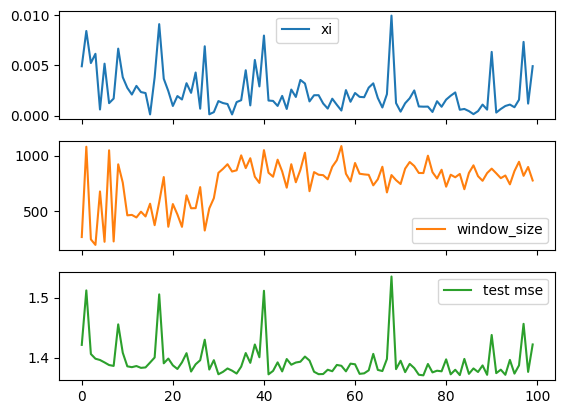

BEST TRIAL PARAMETERS
{'xi': 0.0008857920485321566, 'window_size': 844}


In [11]:
trial_data = plot_optuna_study(study)

In [12]:
trial_data

,xi,window_size,test mse
0,0.004919,266,1.421292
1,0.008437,1082,1.512252
2,0.005241,245,1.406036
3,0.006162,195,1.398205
4,0.000606,678,1.396033
...,...,...,...
95,0.000830,862,1.373306
96,0.001580,946,1.387080
97,0.007350,819,1.456446
98,0.001193,899,1.376196


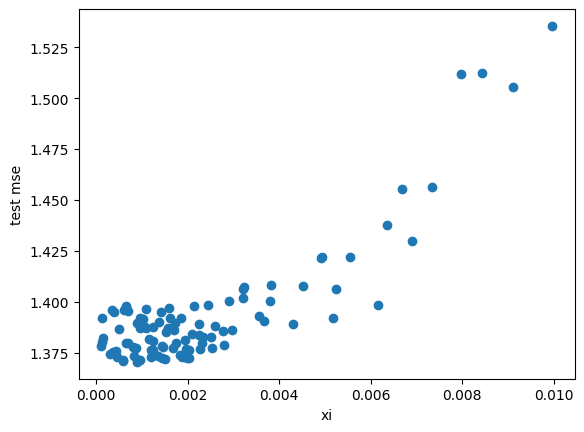

In [44]:
plt.scatter(trial_data['xi'], trial_data['test mse'])
plt.xlabel('xi')
plt.ylabel('test mse')
plt.show()

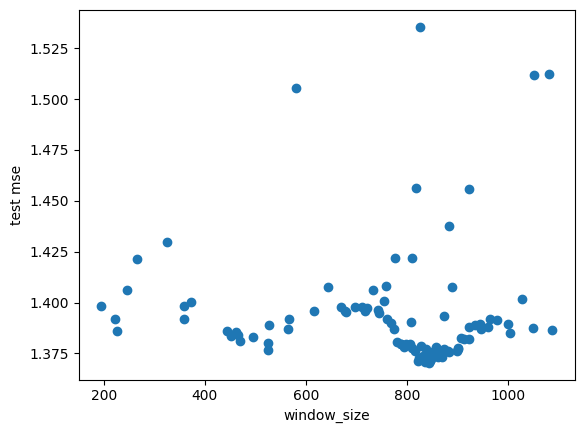

In [42]:
plt.scatter(trial_data['window_size'], trial_data['test mse'])
plt.xlabel('window_size')
plt.ylabel('test mse')
plt.show()

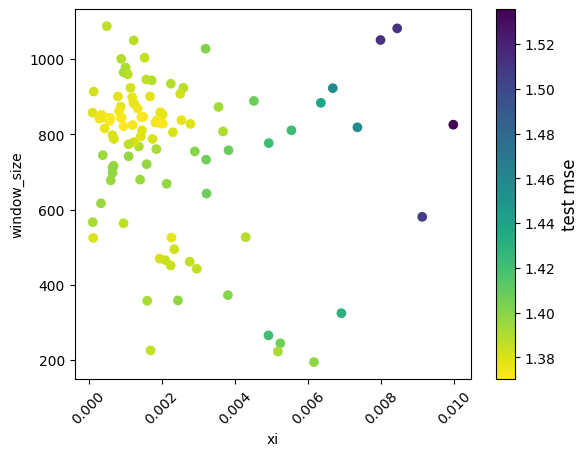

In [52]:
my_plot = plt.scatter(trial_data['xi'], trial_data['window_size'], c=trial_data['test mse'], cmap='viridis_r')
cbar = plt.colorbar(my_plot)
cbar.set_label('test mse', fontsize=12)
plt.xlabel('xi')
plt.ylabel('window_size')
#plt.xlim(0, 0.002)
#plt.ylim(600, 1000)
plt.xticks(rotation=45)
plt.show()

In [51]:
trial_data.sort_values('test mse').head(10)

,xi,window_size,test mse
75,0.000886,844,1.370437
83,0.000579,836,1.370849
89,0.000592,844,1.371292
93,0.000954,822,1.371330
74,0.000906,845,1.371431
41,0.001498,847,1.372101
81,0.001978,829,1.372145
30,0.001444,846,1.372235
52,0.002030,829,1.372382
53,0.001204,825,1.372626


In [53]:
preds = sliding_window_dixon_coles_predictions(matches, window_size=850, prediction_days=14, xi=0.0009)
preds.brier_total_goals.mean()

Processing league: ENG-Premier League
Error training model for ENG-Premier League between 2020-03-27 19:00:00+00:00 and 2022-07-25 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2020-04-03 19:00:00+00:00 and 2022-08-01 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-04-02 19:00:00+00:00 and 2023-07-31 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2021-04-09 19:00:00+00:00 and 2023-08-07 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-04-08 19:00:00+00:00 and 2024-08-05 19:00:00+00:00: Both teams must have been in the training data.
Error training model for ENG-Premier League between 2022-04-15 19:00:00+00:00 and 2024-08-12 19:00:00+00:00: Both teams must have been in the training data.
Processing league: E

array([1.37157089])